# Temperature Prediction Model

## Data Description

Korean Meteorological Administration over Seoul, South Korea uses LDAPS- model to produce umerical weather prediction. The data provided consists of summer data of year from 2013 to 2017. This data has been considered here for bias correction of maximum and minimum air temperature prediction for next day. The input data is largely composed of the LDAPS model's next-day forecast data, in-situ maximum and minimum temperatures of present-day, and geographic auxiliary variables. 

There are two outputs (i.e. next-day maximum and minimum air temperatures) in this data. Hindcast validation was conducted for the period from 2015 to 2017.

We have to build a regression model which can predict our target variables.

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold, cross_val_score
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.utils import resample
import pickle

import warnings
warnings.filterwarnings('ignore')

### Loading Dataset

In [2]:
df= pd.read_csv(r"temperature.csv", parse_dates=["Date"])
df.head()

,station,Date,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,LDAPS_LH,...,LDAPS_PPT2,LDAPS_PPT3,LDAPS_PPT4,lat,lon,DEM,Slope,Solar radiation,Next_Tmax,Next_Tmin
0,1.0,2013-06-30,28.7,21.4,58.255688,91.116364,28.074101,23.006936,6.818887,69.451805,...,0.0,0.0,0.0,37.6046,126.991,212.3350,2.7850,5992.895996,29.1,21.2
1,2.0,2013-06-30,31.9,21.6,52.263397,90.604721,29.850689,24.035009,5.691890,51.937448,...,0.0,0.0,0.0,37.6046,127.032,44.7624,0.5141,5869.312500,30.5,22.5
2,3.0,2013-06-30,31.6,23.3,48.690479,83.973587,30.091292,24.565633,6.138224,20.573050,...,0.0,0.0,0.0,37.5776,127.058,33.3068,0.2661,5863.555664,31.1,23.9
3,4.0,2013-06-30,32.0,23.4,58.239788,96.483688,29.704629,23.326177,5.650050,65.727144,...,0.0,0.0,0.0,37.6450,127.022,45.7160,2.5348,5856.964844,31.7,24.3
4,5.0,2013-06-30,31.4,21.9,56.174095,90.155128,29.113934,23.486480,5.735004,107.965535,...,0.0,0.0,0.0,37.5507,127.135,35.0380,0.5055,5859.552246,31.2,22.5


In [3]:
df.columns

Index(['station', 'Date', 'Present_Tmax', 'Present_Tmin', 'LDAPS_RHmin',
       'LDAPS_RHmax', 'LDAPS_Tmax_lapse', 'LDAPS_Tmin_lapse', 'LDAPS_WS',
       'LDAPS_LH', 'LDAPS_CC1', 'LDAPS_CC2', 'LDAPS_CC3', 'LDAPS_CC4',
       'LDAPS_PPT1', 'LDAPS_PPT2', 'LDAPS_PPT3', 'LDAPS_PPT4', 'lat', 'lon',
       'DEM', 'Slope', 'Solar radiation', 'Next_Tmax', 'Next_Tmin'],
      dtype='object')

#### Columns:

1. station - used weather station number: 1 to 25

2. Date - Present day: yyyy-mm-dd ('2013-06-30' to '2017-08-30')

3. Present_Tmax - Maximum air temperature between 0 and 21 h on the present day (Â°C): 20 to 37.6

4. Present_Tmin - Minimum air temperature between 0 and 21 h on the present day (Â°C): 11.3 to 29.9

5. LDAPS_RHmin - LDAPS model forecast of next-day minimum relative humidity (%): 19.8 to 98.5

6. LDAPS_RHmax - LDAPS model forecast of next-day maximum relative humidity (%): 58.9 to 100

7. LDAPS_Tmax_lapse - LDAPS model forecast of next-day maximum air temperature applied lapse rate (Â°C): 17.6 to 38.5

8. LDAPS_Tmin_lapse - LDAPS model forecast of next-day minimum air temperature applied lapse rate (Â°C): 14.3 to 29.6

9. LDAPS_WS - LDAPS model forecast of next-day average wind speed (m/s): 2.9 to 21.9

10. LDAPS_LH - LDAPS model forecast of next-day average latent heat flux (W/m2): -13.6 to 213.4

11. LDAPS_CC1 - LDAPS model forecast of next-day 1st 6-hour split average cloud cover (0-5 h) (%): 0 to 0.97

12. LDAPS_CC2 - LDAPS model forecast of next-day 2nd 6-hour split average cloud cover (6-11 h) (%): 0 to 0.97

13. LDAPS_CC3 - LDAPS model forecast of next-day 3rd 6-hour split average cloud cover (12-17 h) (%): 0 to 0.98

14. LDAPS_CC4 - LDAPS model forecast of next-day 4th 6-hour split average cloud cover (18-23 h) (%): 0 to 0.97

15. LDAPS_PPT1 - LDAPS model forecast of next-day 1st 6-hour split average precipitation (0-5 h) (%): 0 to 23.7

16. LDAPS_PPT2 - LDAPS model forecast of next-day 2nd 6-hour split average precipitation (6-11 h) (%): 0 to 21.6

17. LDAPS_PPT3 - LDAPS model forecast of next-day 3rd 6-hour split average precipitation (12-17 h) (%): 0 to 15.8

18. LDAPS_PPT4 - LDAPS model forecast of next-day 4th 6-hour split average precipitation (18-23 h) (%): 0 to 16.7

19. lat - Latitude (Â°): 37.456 to 37.645

20. lon - Longitude (Â°): 126.826 to 127.135

21. DEM - Elevation (m): 12.4 to 212.3

22. Slope - Slope (Â°): 0.1 to 5.2

23. Solar radiation - Daily incoming solar radiation (wh/m2): 4329.5 to 5992.9

##### Target Variables

24. Next_Tmax - The next-day maximum air temperature (Â°C): 17.4 to 38.9

25. Next_Tmin - The next-day minimum air temperature (Â°C): 11.3 to 29.8T

### Dealing with null values

In [4]:
df.shape

(7752, 25)

number of rows= 7752

number of columns= 25

In [5]:
df.drop_duplicates(inplace=True)
df.shape

(7752, 25)

No duplicate data exist

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7752 entries, 0 to 7751
Data columns (total 25 columns):
station             7750 non-null float64
Date                7750 non-null datetime64[ns]
Present_Tmax        7682 non-null float64
Present_Tmin        7682 non-null float64
LDAPS_RHmin         7677 non-null float64
LDAPS_RHmax         7677 non-null float64
LDAPS_Tmax_lapse    7677 non-null float64
LDAPS_Tmin_lapse    7677 non-null float64
LDAPS_WS            7677 non-null float64
LDAPS_LH            7677 non-null float64
LDAPS_CC1           7677 non-null float64
LDAPS_CC2           7677 non-null float64
LDAPS_CC3           7677 non-null float64
LDAPS_CC4           7677 non-null float64
LDAPS_PPT1          7677 non-null float64
LDAPS_PPT2          7677 non-null float64
LDAPS_PPT3          7677 non-null float64
LDAPS_PPT4          7677 non-null float64
lat                 7752 non-null float64
lon                 7752 non-null float64
DEM                 7752 non-null float64
Slop

We observe null values so we will first deal with them and then proceed with or EDA

In [7]:
df.isnull().sum()

station              2
Date                 2
Present_Tmax        70
Present_Tmin        70
LDAPS_RHmin         75
LDAPS_RHmax         75
LDAPS_Tmax_lapse    75
LDAPS_Tmin_lapse    75
LDAPS_WS            75
LDAPS_LH            75
LDAPS_CC1           75
LDAPS_CC2           75
LDAPS_CC3           75
LDAPS_CC4           75
LDAPS_PPT1          75
LDAPS_PPT2          75
LDAPS_PPT3          75
LDAPS_PPT4          75
lat                  0
lon                  0
DEM                  0
Slope                0
Solar radiation      0
Next_Tmax           27
Next_Tmin           27
dtype: int64

Since our target variables has null values we will drop those rows. Also station column has only 2 null values so we can drop those rows.

In [8]:
df=df[df['Next_Tmin'].notnull()]

df=df[df['station'].notnull()]

We will fill all the null values using KNN Imputer.

In [9]:
from sklearn.impute import KNNImputer
knn_imp=KNNImputer()
df1=knn_imp.fit_transform(df[["Present_Tmax","Present_Tmin"]])
df[["Present_Tmax","Present_Tmin"]]=df1

In [10]:
from sklearn.impute import KNNImputer
knn_imp=KNNImputer()
df1=knn_imp.fit_transform(df[["LDAPS_RHmin","LDAPS_RHmax","LDAPS_Tmin_lapse","LDAPS_Tmax_lapse","LDAPS_WS","LDAPS_LH",
                              "LDAPS_CC1","LDAPS_CC2","LDAPS_CC3","LDAPS_CC4","LDAPS_PPT1",
                             "LDAPS_PPT2","LDAPS_PPT3","LDAPS_PPT4"]])
df[["LDAPS_RHmin","LDAPS_RHmax","LDAPS_Tmin_lapse","LDAPS_Tmax_lapse","LDAPS_WS","LDAPS_LH",
                              "LDAPS_CC1","LDAPS_CC2","LDAPS_CC3","LDAPS_CC4","LDAPS_PPT1",
                             "LDAPS_PPT2","LDAPS_PPT3","LDAPS_PPT4"]]=df1

In [11]:
df.isnull().sum()

station             0
Date                0
Present_Tmax        0
Present_Tmin        0
LDAPS_RHmin         0
LDAPS_RHmax         0
LDAPS_Tmax_lapse    0
LDAPS_Tmin_lapse    0
LDAPS_WS            0
LDAPS_LH            0
LDAPS_CC1           0
LDAPS_CC2           0
LDAPS_CC3           0
LDAPS_CC4           0
LDAPS_PPT1          0
LDAPS_PPT2          0
LDAPS_PPT3          0
LDAPS_PPT4          0
lat                 0
lon                 0
DEM                 0
Slope               0
Solar radiation     0
Next_Tmax           0
Next_Tmin           0
dtype: int64

We have successfully dealt with all the null values. We will now move to EDA part.

## EDA

In [12]:
df.shape

(7723, 25)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7723 entries, 0 to 7749
Data columns (total 25 columns):
station             7723 non-null float64
Date                7723 non-null datetime64[ns]
Present_Tmax        7723 non-null float64
Present_Tmin        7723 non-null float64
LDAPS_RHmin         7723 non-null float64
LDAPS_RHmax         7723 non-null float64
LDAPS_Tmax_lapse    7723 non-null float64
LDAPS_Tmin_lapse    7723 non-null float64
LDAPS_WS            7723 non-null float64
LDAPS_LH            7723 non-null float64
LDAPS_CC1           7723 non-null float64
LDAPS_CC2           7723 non-null float64
LDAPS_CC3           7723 non-null float64
LDAPS_CC4           7723 non-null float64
LDAPS_PPT1          7723 non-null float64
LDAPS_PPT2          7723 non-null float64
LDAPS_PPT3          7723 non-null float64
LDAPS_PPT4          7723 non-null float64
lat                 7723 non-null float64
lon                 7723 non-null float64
DEM                 7723 non-null float64
Slop

In [14]:
df_dates=pd.DataFrame()
df_dates["Month"]=df["Date"].dt.month_name()
df_dates["day"]=df["Date"].dt.day_name()
df_dates["year"]=df["Date"].dt.year

In [15]:
dff=pd.concat([df,df_dates],axis=1)
dff.head()

,station,Date,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,LDAPS_LH,...,lat,lon,DEM,Slope,Solar radiation,Next_Tmax,Next_Tmin,Month,day,year
0,1.0,2013-06-30,28.7,21.4,58.255688,91.116364,28.074101,23.006936,6.818887,69.451805,...,37.6046,126.991,212.3350,2.7850,5992.895996,29.1,21.2,June,Sunday,2013
1,2.0,2013-06-30,31.9,21.6,52.263397,90.604721,29.850689,24.035009,5.691890,51.937448,...,37.6046,127.032,44.7624,0.5141,5869.312500,30.5,22.5,June,Sunday,2013
2,3.0,2013-06-30,31.6,23.3,48.690479,83.973587,30.091292,24.565633,6.138224,20.573050,...,37.5776,127.058,33.3068,0.2661,5863.555664,31.1,23.9,June,Sunday,2013
3,4.0,2013-06-30,32.0,23.4,58.239788,96.483688,29.704629,23.326177,5.650050,65.727144,...,37.6450,127.022,45.7160,2.5348,5856.964844,31.7,24.3,June,Sunday,2013
4,5.0,2013-06-30,31.4,21.9,56.174095,90.155128,29.113934,23.486480,5.735004,107.965535,...,37.5507,127.135,35.0380,0.5055,5859.552246,31.2,22.5,June,Sunday,2013


In [16]:
obj_lst=["day","Month"]
lab_enc= LabelEncoder()
for i in obj_lst:
    df1= lab_enc.fit_transform(dff[i])
    dff[i]=df1
dff.head()

,station,Date,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,LDAPS_LH,...,lat,lon,DEM,Slope,Solar radiation,Next_Tmax,Next_Tmin,Month,day,year
0,1.0,2013-06-30,28.7,21.4,58.255688,91.116364,28.074101,23.006936,6.818887,69.451805,...,37.6046,126.991,212.3350,2.7850,5992.895996,29.1,21.2,6,3,2013
1,2.0,2013-06-30,31.9,21.6,52.263397,90.604721,29.850689,24.035009,5.691890,51.937448,...,37.6046,127.032,44.7624,0.5141,5869.312500,30.5,22.5,6,3,2013
2,3.0,2013-06-30,31.6,23.3,48.690479,83.973587,30.091292,24.565633,6.138224,20.573050,...,37.5776,127.058,33.3068,0.2661,5863.555664,31.1,23.9,6,3,2013
3,4.0,2013-06-30,32.0,23.4,58.239788,96.483688,29.704629,23.326177,5.650050,65.727144,...,37.6450,127.022,45.7160,2.5348,5856.964844,31.7,24.3,6,3,2013
4,5.0,2013-06-30,31.4,21.9,56.174095,90.155128,29.113934,23.486480,5.735004,107.965535,...,37.5507,127.135,35.0380,0.5055,5859.552246,31.2,22.5,6,3,2013


In [17]:
df.describe()

,station,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,LDAPS_LH,LDAPS_CC1,...,LDAPS_PPT2,LDAPS_PPT3,LDAPS_PPT4,lat,lon,DEM,Slope,Solar radiation,Next_Tmax,Next_Tmin
count,7723.000000,7723.000000,7723.000000,7723.000000,7723.000000,7723.000000,7723.000000,7723.000000,7723.000000,7723.000000,...,7723.000000,7723.000000,7723.000000,7723.000000,7723.000000,7723.000000,7723.000000,7723.000000,7723.000000,7723.000000
mean,13.008157,29.769816,23.225316,56.740769,88.371467,29.616654,23.512217,7.095360,62.458809,0.368452,...,0.481598,0.275122,0.267333,37.544753,126.991373,61.913798,1.258368,5342.112868,30.275437,22.932837
std,7.214034,2.956157,2.400841,14.571702,7.155898,2.927713,2.330885,2.165080,33.505514,0.260963,...,1.736231,1.138909,1.185557,0.050370,0.079318,54.308844,1.370719,429.072274,3.123441,2.483181
min,1.000000,20.000000,11.300000,19.794666,58.936283,17.624954,14.272646,2.882580,-13.603212,0.000000,...,0.000000,0.000000,0.000000,37.456200,126.826000,12.370000,0.098500,4329.520508,17.400000,11.300000
25%,7.000000,27.800000,21.700000,46.045780,84.291611,27.696327,22.114527,5.686500,37.460390,0.148259,...,0.000000,0.000000,0.000000,37.510200,126.937000,28.700000,0.271300,4999.018555,28.200000,21.300000
50%,13.000000,29.900000,23.400000,55.266701,89.699196,29.664030,23.733589,6.564141,57.299645,0.319678,...,0.000000,0.000000,0.000000,37.550700,126.995000,45.716000,0.618000,5437.534180,30.500000,23.100000
75%,19.000000,32.000000,24.900000,66.991833,93.702629,31.684914,25.134434,7.996720,83.884903,0.571472,...,0.024025,0.009648,0.000696,37.577600,127.042000,59.832400,1.767800,5728.624512,32.600000,24.600000
max,25.000000,37.600000,29.900000,98.524734,100.000153,38.542255,29.619342,21.857621,213.414006,0.967277,...,21.621661,15.841235,16.655469,37.645000,127.135000,212.335000,5.178200,5992.895996,38.900000,29.800000


 we observe mean, standard deviation, Minimum, maximum and quartiles of data.

### Check for Correlation

In [18]:
df.corr()

,station,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,LDAPS_LH,LDAPS_CC1,...,LDAPS_PPT2,LDAPS_PPT3,LDAPS_PPT4,lat,lon,DEM,Slope,Solar radiation,Next_Tmax,Next_Tmin
station,1.000000,0.113068,0.132188,-0.068285,-0.168195,0.070062,0.104919,0.004444,-0.132215,0.005876,...,-0.009600,-0.014191,-0.011564,-0.238460,-0.118755,-0.257215,-0.091449,-0.020255,0.108306,0.128719
Present_Tmax,0.113068,1.000000,0.617749,-0.206953,-0.304556,0.568932,0.623175,-0.124903,0.133108,-0.313537,...,-0.103758,-0.126289,-0.105282,-0.054255,0.007439,-0.188650,-0.106727,-0.026797,0.609838,0.622235
Present_Tmin,0.132188,0.617749,1.000000,0.120531,-0.018345,0.462196,0.762384,-0.038305,-0.012673,0.083284,...,0.065323,-0.051836,-0.068798,-0.080914,-0.045411,-0.252359,-0.147869,0.051451,0.470231,0.796415
LDAPS_RHmin,-0.068285,-0.206953,0.120531,1.000000,0.578708,-0.568968,0.086273,0.291812,-0.072808,0.613201,...,0.390614,0.237664,0.165221,0.085414,-0.077668,0.101430,0.122570,0.242477,-0.442575,0.092969
LDAPS_RHmax,-0.168195,-0.304556,-0.018345,0.578708,1.000000,-0.377209,-0.117417,0.132796,0.237706,0.436276,...,0.228162,0.132484,0.115835,0.194563,0.024993,0.176848,0.218913,0.147966,-0.287554,-0.075364
LDAPS_Tmax_lapse,0.070062,0.568932,0.462196,-0.568968,-0.377209,1.000000,0.653320,-0.316285,0.044499,-0.440665,...,-0.249063,-0.194624,-0.166970,-0.044057,0.090174,-0.180786,-0.163377,0.046247,0.828267,0.586571
LDAPS_Tmin_lapse,0.104919,0.623175,0.762384,0.086273,-0.117417,0.653320,1.000000,-0.133353,-0.138403,0.008993,...,-0.002782,-0.093480,-0.099826,-0.098540,-0.026887,-0.196883,-0.186902,0.157899,0.586746,0.881342
LDAPS_WS,0.004444,-0.124903,-0.038305,0.291812,0.132796,-0.316285,-0.133353,1.000000,0.003230,0.287090,...,0.183197,0.148422,0.132244,0.033959,-0.063031,0.189009,0.168964,0.121241,-0.348707,-0.100941
LDAPS_LH,-0.132215,0.133108,-0.012673,-0.072808,0.237706,0.044499,-0.138403,0.003230,1.000000,-0.148572,...,-0.084894,0.009076,0.012848,0.131417,0.024023,0.054989,0.086688,-0.047341,0.155614,-0.058755
LDAPS_CC1,0.005876,-0.313537,0.083284,0.613201,0.436276,-0.440665,0.008993,0.287090,-0.148572,1.000000,...,0.389797,0.167147,0.089078,-0.009449,-0.008468,-0.014951,-0.021798,0.217724,-0.456087,-0.012768


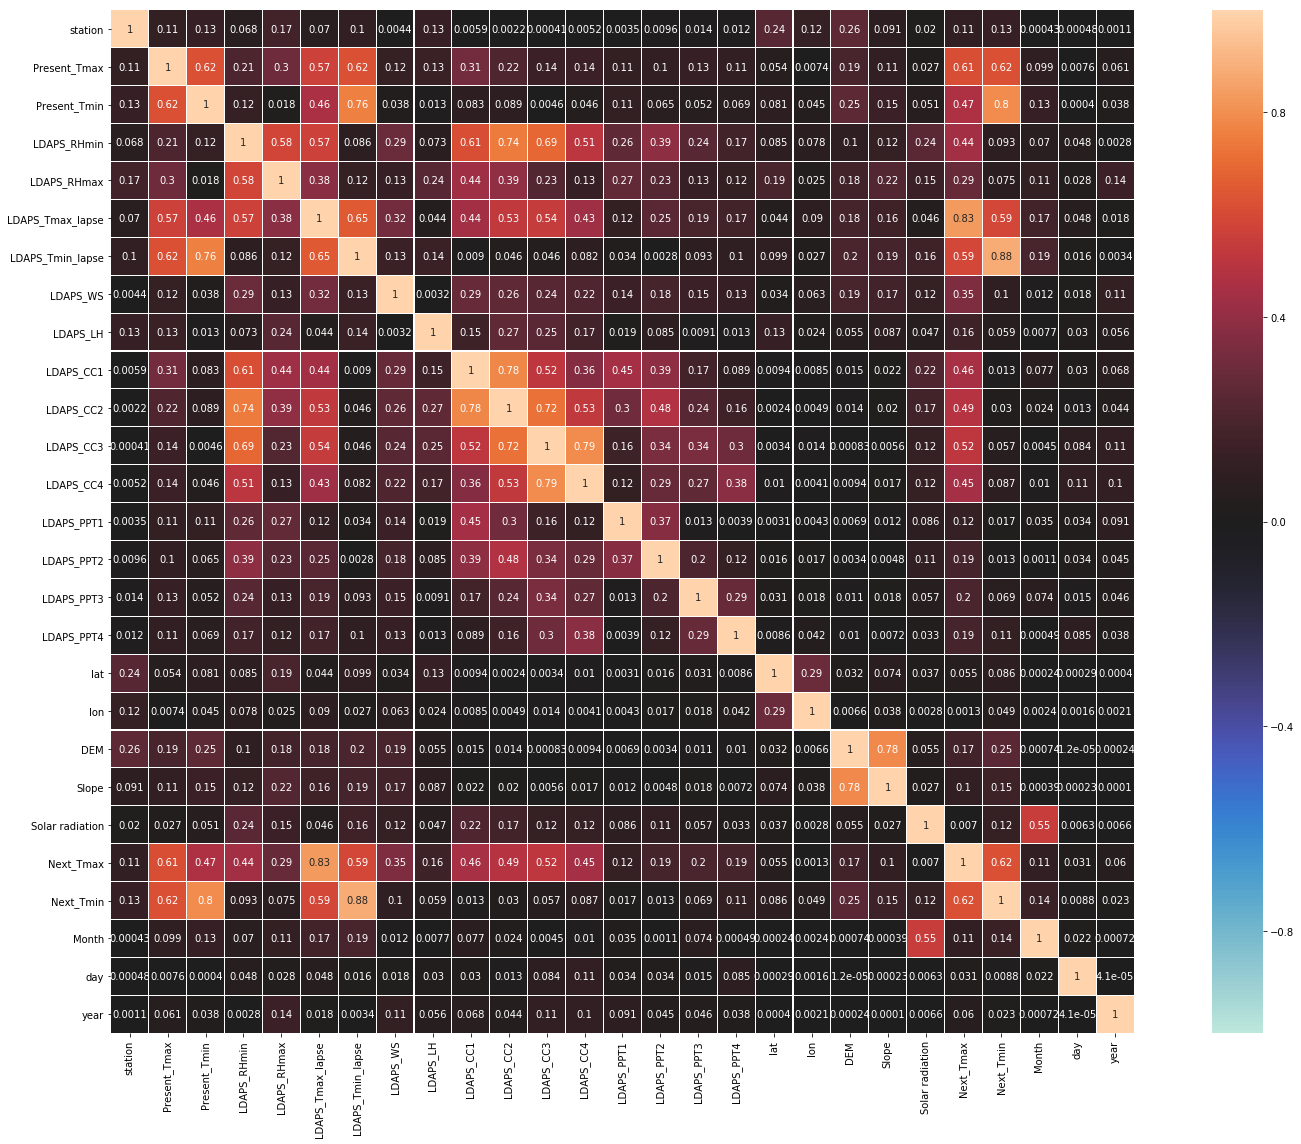

In [19]:
## HeatMap
dff_corr= dff.corr().abs()
plt.figure(figsize=(22,16))
sns.heatmap(dff_corr, vmin=-1, vmax=1, annot=True, square=True, center=0, fmt='.2g', linewidth=.1)
plt.tight_layout()

In [20]:
corr_mat=dff.corr()
corr_mat["Next_Tmax"].sort_values(ascending=False)

Next_Tmax           1.000000
LDAPS_Tmax_lapse    0.828267
Next_Tmin           0.620119
Present_Tmax        0.609838
LDAPS_Tmin_lapse    0.586746
Present_Tmin        0.470231
LDAPS_LH            0.155614
station             0.108306
Month               0.107238
year                0.060216
day                 0.031343
Solar radiation     0.007025
lon                 0.001306
lat                -0.055327
Slope              -0.104535
LDAPS_PPT1         -0.124823
DEM                -0.174521
LDAPS_PPT2         -0.185386
LDAPS_PPT4         -0.186663
LDAPS_PPT3         -0.202819
LDAPS_RHmax        -0.287554
LDAPS_WS           -0.348707
LDAPS_RHmin        -0.442575
LDAPS_CC4          -0.449921
LDAPS_CC1          -0.456087
LDAPS_CC2          -0.494527
LDAPS_CC3          -0.518904
Name: Next_Tmax, dtype: float64

Max Correlation : LADPS_Tmax_lapse

Min Correlation : lon

In [21]:
corr_mat=dff.corr()
corr_mat["Next_Tmin"].sort_values(ascending=False)

Next_Tmin           1.000000
LDAPS_Tmin_lapse    0.881342
Present_Tmin        0.796415
Present_Tmax        0.622235
Next_Tmax           0.620119
LDAPS_Tmax_lapse    0.586571
Month               0.139733
station             0.128719
Solar radiation     0.118717
LDAPS_RHmin         0.092969
LDAPS_CC2           0.029691
year                0.023229
LDAPS_PPT1          0.017086
day                 0.008839
LDAPS_PPT2         -0.012719
LDAPS_CC1          -0.012768
lon                -0.048763
LDAPS_CC3          -0.056762
LDAPS_LH           -0.058755
LDAPS_PPT3         -0.068878
LDAPS_RHmax        -0.075364
lat                -0.085599
LDAPS_CC4          -0.087183
LDAPS_WS           -0.100941
LDAPS_PPT4         -0.110478
Slope              -0.148947
DEM                -0.249255
Name: Next_Tmin, dtype: float64

Max Correlation : LADPS_Tmin_lapse

Min Correlation : LDAPS_PPT1

To Check for multicollinearity we will now plot a few graphs.

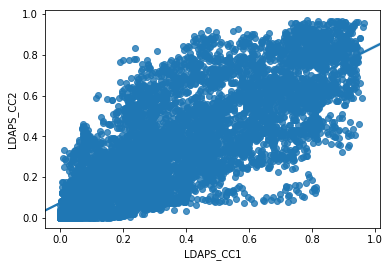

In [22]:
sns.regplot(x="LDAPS_CC1", y= "LDAPS_CC2", data= dff)

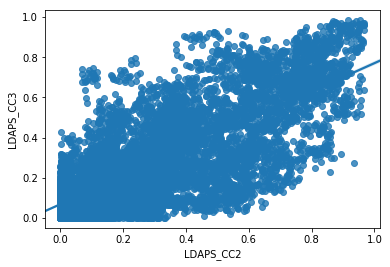

In [23]:
sns.regplot(x="LDAPS_CC2", y= "LDAPS_CC3", data= dff)

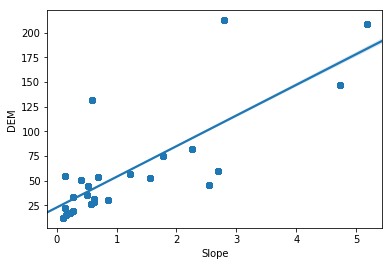

In [24]:
sns.regplot(x="Slope", y= "DEM", data= dff)

In [25]:
dff=dff.drop(columns=["Date"])

#### Checking for Outliers

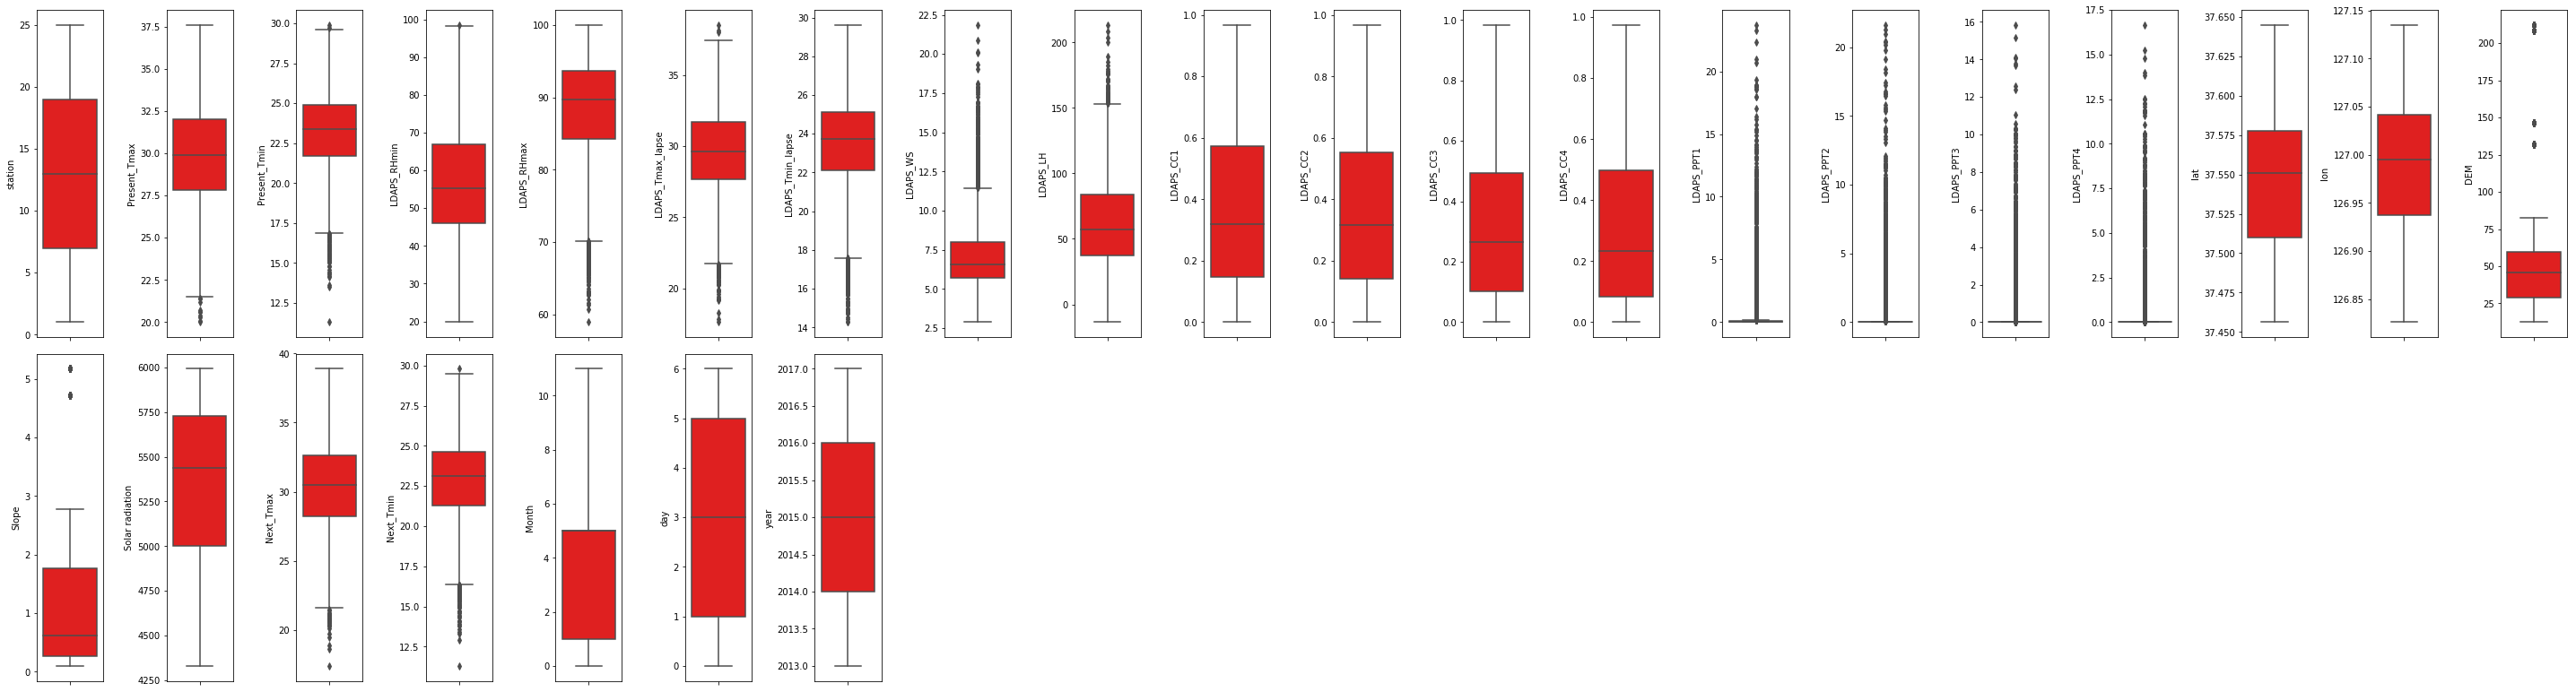

In [26]:
collist=dff.columns.values
plt.figure(figsize=(40,80))
for i in range(0,len(collist)):
    plt.subplot(15,20,i+1)
    sns.boxplot(dff[collist[i]],color='red',orient='v')
    plt.tight_layout()

We observe outliers in most of our column

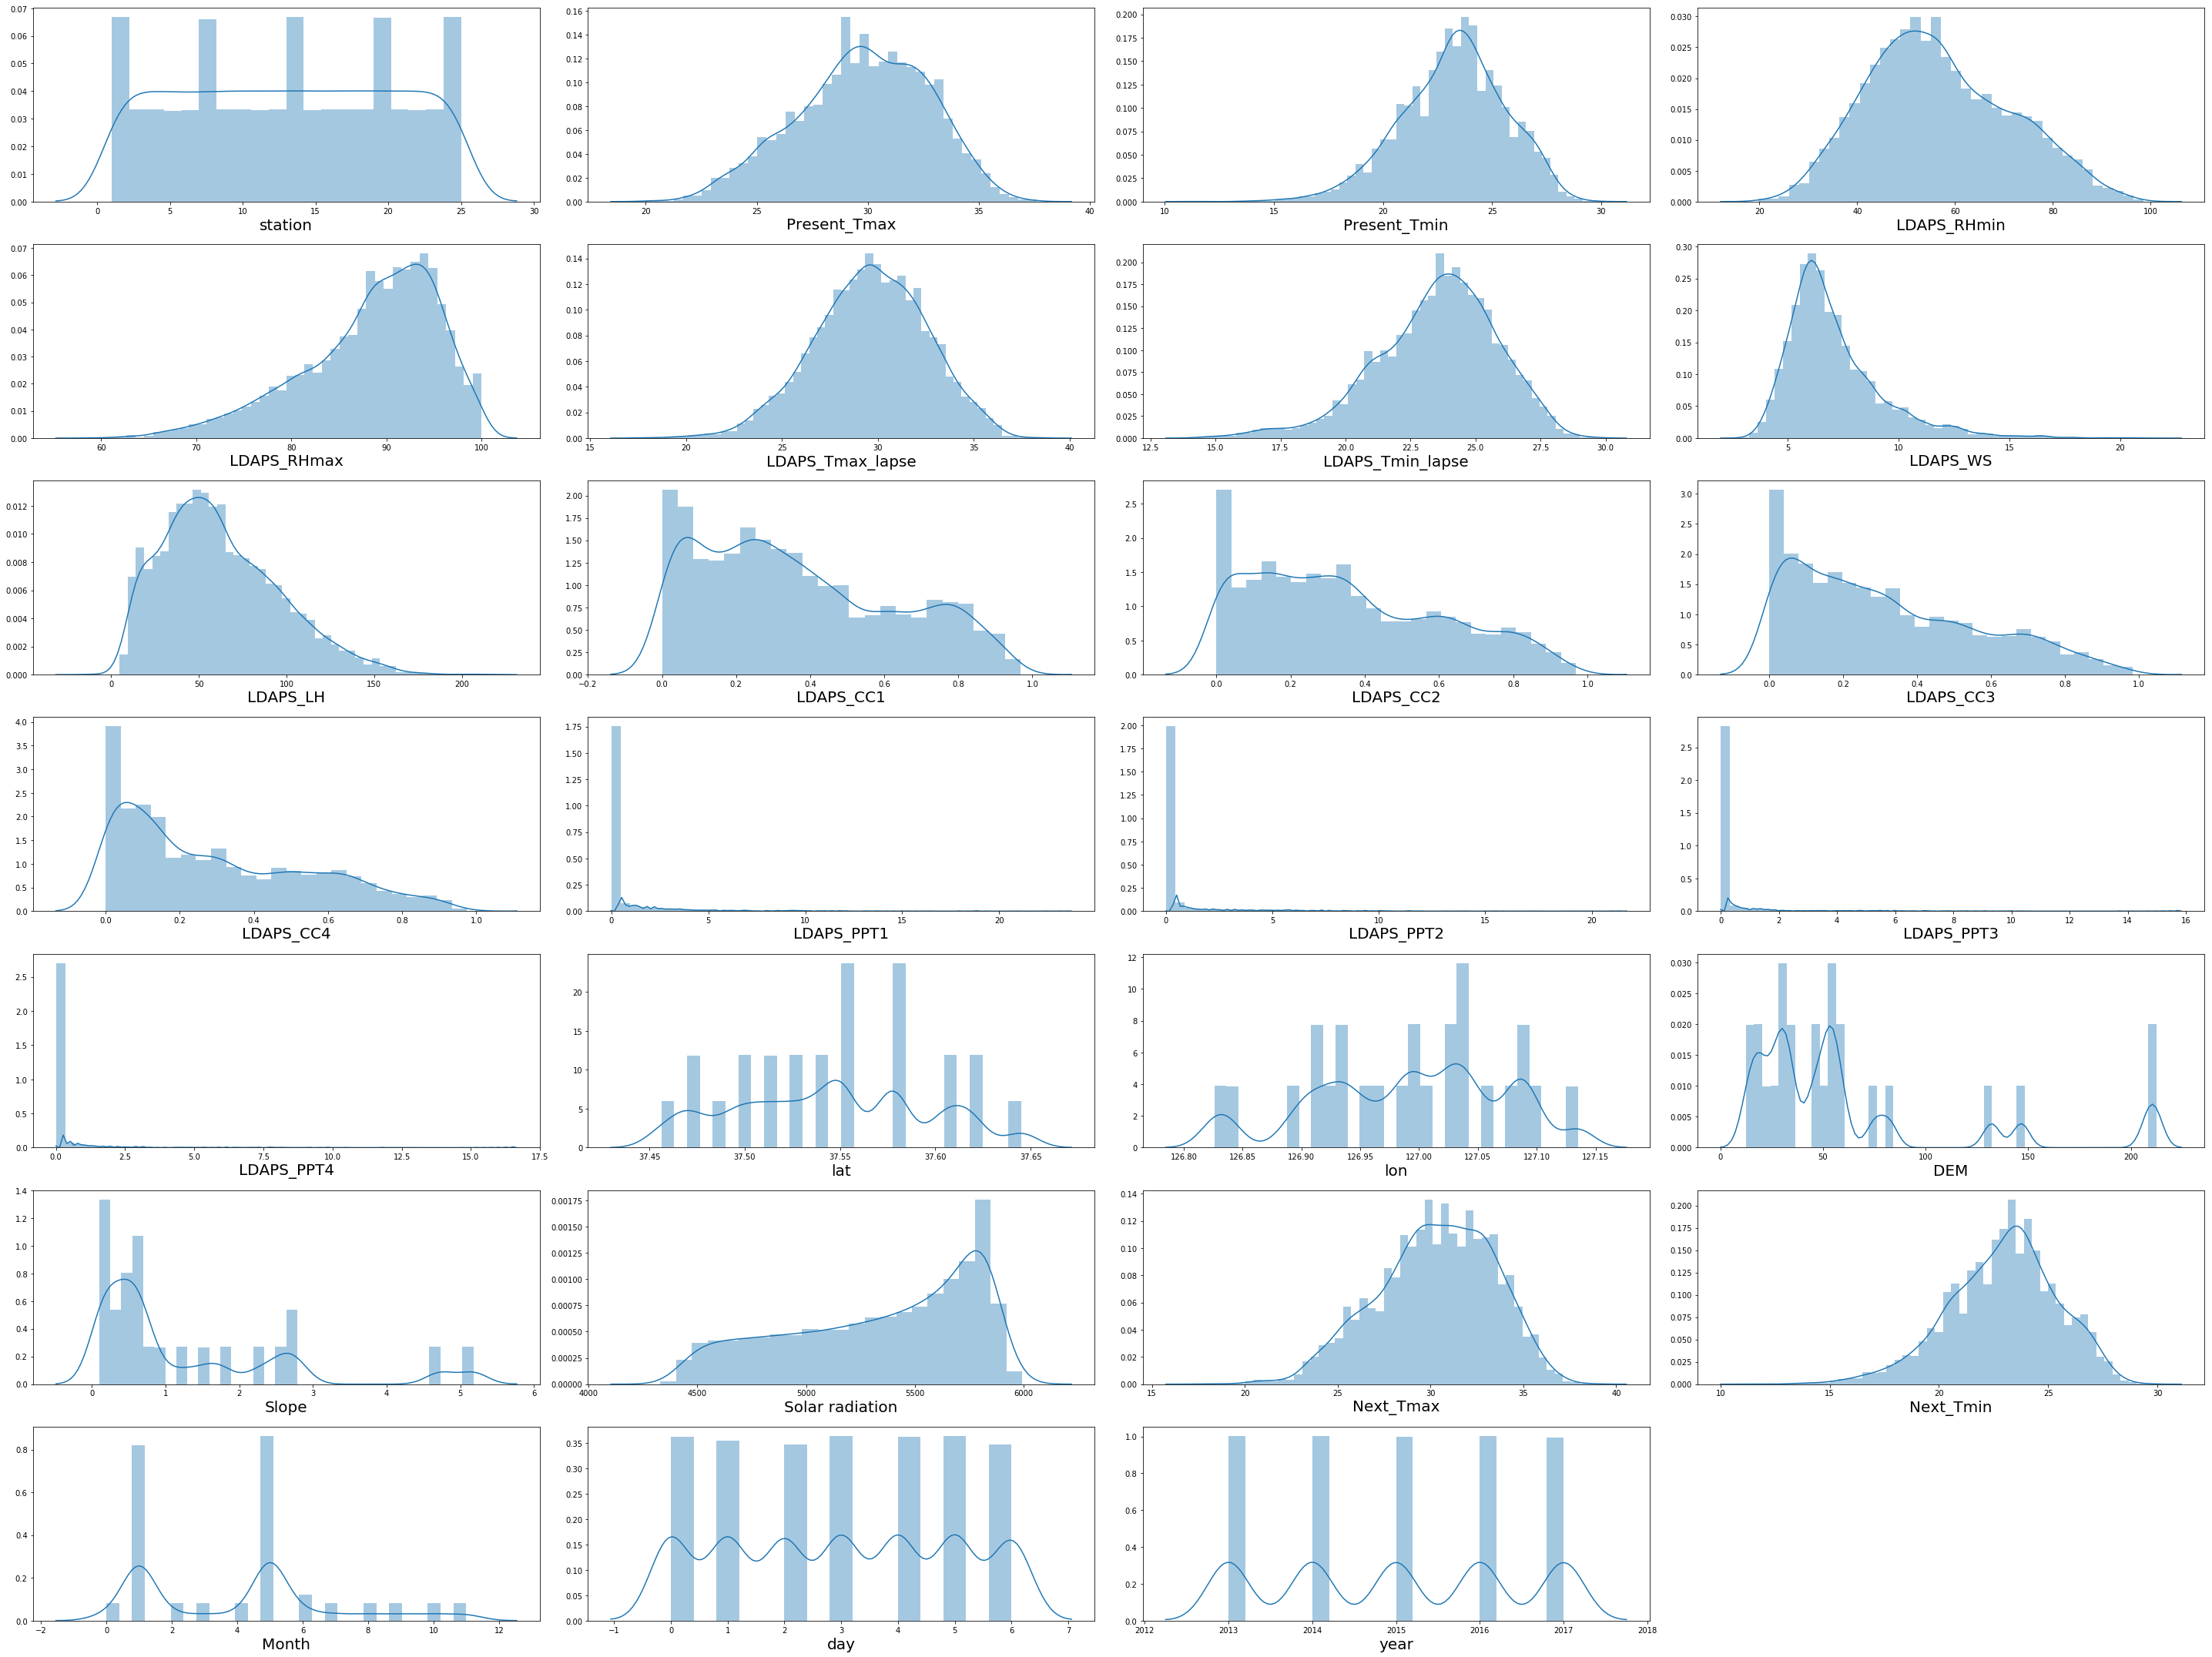

In [27]:
## checking for Normal Distribution of curve
plt.figure(figsize=(40,30),facecolor='white')
plotnumber=1

for column in dff:
    if plotnumber<=30:
        ax=plt.subplot(7,4,plotnumber)
        sns.distplot(dff[column])
        plt.xlabel(column, fontsize=20)
    plotnumber+=1
plt.tight_layout()

We observe skewness in our data. Hence the normal distribution curves here are irrelevant.

## Data Cleaning

In [28]:
from scipy import stats
z=np.abs(stats.zscore(dff))
index=(np.where(z>3)[0])
df_new=dff.drop(df.index[index])
df_new.shape

(6862, 27)

In [29]:
print("percentage of dataloss = ",((7752-7435)/7752)*100)

percentage of dataloss =  4.089267285861713


Our percentage of data loss after removing outliers and ealing with all the null values is 4.08% and thus we will now proceed to check skewess and to further building model

#### Check for skwness

In [30]:
df_new.skew()

station            -0.001134
Present_Tmax       -0.274349
Present_Tmin       -0.224295
LDAPS_RHmin         0.307011
LDAPS_RHmax        -0.686525
LDAPS_Tmax_lapse   -0.108202
LDAPS_Tmin_lapse   -0.379989
LDAPS_WS            1.089350
LDAPS_LH            0.567856
LDAPS_CC1           0.597108
LDAPS_CC2           0.504636
LDAPS_CC3           0.701848
LDAPS_CC4           0.710983
LDAPS_PPT1          3.724977
LDAPS_PPT2          4.858163
LDAPS_PPT3          5.511467
LDAPS_PPT4          5.915476
lat                 0.106931
lon                -0.276466
DEM                 1.761917
Slope               1.591973
Solar radiation    -0.507643
Next_Tmax          -0.269169
Next_Tmin          -0.238413
Month               0.529151
day                -0.021909
year                0.013424
dtype: float64

In [31]:
list=["LDAPS_WS","LDAPS_LH","Solar radiation","LDAPS_Tmin_lapse","LDAPS_Tmax_lapse","LDAPS_RHmin", "LDAPS_RHmax",
      "LDAPS_CC4","LDAPS_CC3"]
for val in list:
    if df_new.skew().loc[val]>0.55 or df_new.skew().loc[val]<-0.55:
        df_new[val]=np.log(df_new[val])
    print(val,"  ",df_new.skew().loc[val])

LDAPS_WS    0.379286782401107
LDAPS_LH    -0.6686470781702276
Solar radiation    -0.507643373430475
LDAPS_Tmin_lapse    -0.3799886498068573
LDAPS_Tmax_lapse    -0.10820201750469906
LDAPS_RHmin    0.3070110376749564
LDAPS_RHmax    -0.871154698912444
LDAPS_CC4    nan
LDAPS_CC3    nan


In [32]:
list=["LDAPS_PPT1","LDAPS_PPT2","LDAPS_PPT3","LDAPS_PPT4"]
for val in list:
    for i in range(5):
        if df_new.skew().loc[val]>0.55 or df_new.skew().loc[val]<-0.55:
            df_new[val]=np.sqrt(df_new[val])
    print(val,"  ",df_new.skew().loc[val])

LDAPS_PPT1    0.6769316526189318
LDAPS_PPT2    0.9021380692611021
LDAPS_PPT3    1.015637727239635
LDAPS_PPT4    1.3686230921880382


#### Splitting Data

In [33]:
df1=dff.drop(columns=["Next_Tmin"])
df2=dff.drop(columns=["Next_Tmax"])

In [34]:
# for Maximum temperature prediction
x1=df1.drop(columns=["Next_Tmax"],axis=1)
y1=df1["Next_Tmax"]

In [35]:
# for minimum temperature prediction
x2=df2.drop(columns=["Next_Tmin"],axis=1)
y2=df2["Next_Tmin"]

## Model Building

### For Maximum temperature prediction

In [36]:
## Scaling data
scale= StandardScaler()
x1_scaled=scale.fit_transform(x1)

In [71]:
# Splitting Data
x_train, x_test, y_train, y_test = train_test_split(x1_scaled, y1, test_size=0.25, random_state=355)

#### Linear Regression

In [38]:
lm= LinearRegression()
lm.fit(x_train,y_train)
y_pred= lm.predict(x_test)
score_lm=lm.score(x_test,y_test)
print("Linear regression: Accuracy = ",score_lm)
print("Mean Absolute Error= ",mean_absolute_error(y_test,y_pred))
print("Mean Squared Error= ",mean_squared_error(y_test,y_pred))

Linear regression: Accuracy =  0.7669149753271075
Mean Absolute Error=  1.1348977263132212
Mean Squared Error=  2.2791744537297007


#### KNN Regressor

In [39]:
knn_r=KNeighborsRegressor()
knn_r.fit(x_train, y_train)
y_pred= knn_r.predict(x_test)
score_knnr=knn_r.score(x_test,y_test)
print("KNN regression: Accuracy = ",score_knnr)
print("Mean Absolute Error= ",mean_absolute_error(y_test,y_pred))
print("Mean Squared Error= ",mean_squared_error(y_test,y_pred))

KNN regression: Accuracy =  0.8766098965187673
Mean Absolute Error=  0.8055929570170898
Mean Squared Error=  1.2065450025893323


#### Decision Tree Regressor

In [40]:
dt_r= DecisionTreeRegressor()
dt_r.fit(x_train, y_train)
y_pred= dt_r.predict(x_test)
score_dtr=dt_r.score(x_test,y_test)
print("Decision Tree regression: Accuracy = ",score_dtr)
print("Mean Absolute Error= ",mean_absolute_error(y_test,y_pred))
print("Mean Squared Error= ",mean_squared_error(y_test,y_pred))

Decision Tree regression: Accuracy =  0.7738992267948227
Mean Absolute Error=  1.0354738477472811
Mean Squared Error=  2.2108803728638007


#### Model Regularization using LassoCV

In [41]:
lasscv= LassoCV(alphas=None, max_iter=1000, normalize= True)
lasscv.fit(x_train,y_train)
alpha= lasscv.alpha_
lasso_reg= Lasso(alpha)
lasso_reg.fit(x_train,y_train)
lasso_reg.score(x_test,y_test)

0.766915891678586

In [42]:
y_pred=lasso_reg.predict(x_test)
print("Mean Absolute Error= ",mean_absolute_error(y_test,y_pred))
print("Mean Squared Error= ",mean_squared_error(y_test,y_pred))

Mean Absolute Error=  1.134890848299365
Mean Squared Error=  2.2791654933733527


#### Model Evalustion

#### Linear Regression

In [43]:
lm_cv=cross_val_score(lm,x_train, y_train,cv=5).mean()
lm_cv

0.7731104231411958

In [44]:
print("Linear Regression Model: ",(score_lm-lm_cv))

Linear Regression Model:  -0.006195447814088317


#### KNN Regressor

In [45]:
knnr_cv=cross_val_score(knn_r,x_train, y_train,cv=5).mean()
knnr_cv

0.8743850502281644

In [46]:
print("KNN Model: ",(score_knnr-knnr_cv))

KNN Model:  0.002224846290602933


#### Decision Tree Regressor

In [47]:
dtr_cv=cross_val_score(dt_r,x_train, y_train,cv=5).mean()
dtr_cv

0.7807105019414259

In [48]:
print("DecisionTree Model: ",(score_dtr-dtr_cv))

DecisionTree Model:  -0.0068112751466031796


Decision Tree model is our best model based on cross validation score. Now we will tune our model

#### Hyper parametric tuning

In [49]:
dt_r= DecisionTreeRegressor()
grid_param={'criterion':['mse'],
           'max_depth':range(2,20,3),
           'min_samples_leaf':range(1,20,4),
           'min_samples_split':range(2,20,2)}
grid_search= GridSearchCV(estimator=dt_r, param_grid= grid_param, cv=5, n_jobs=-1)
grid_search.fit(x_train, y_train)
best_parameter= grid_search.best_params_
print(best_parameter)

{'criterion': 'mse', 'max_depth': 11, 'min_samples_leaf': 5, 'min_samples_split': 18}


In [72]:
dt_r=DecisionTreeRegressor(criterion='mse',max_depth=14, min_samples_leaf=5, min_samples_split=18)
dt_r.fit(x_train,y_train)
y_pred=dt_r.predict(x_test)
print("R2 Score= ",dt_r.score(x_test,y_test))

R2 Score=  0.8264564662496908


In [73]:
print("Mean Squared Error= ",mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error= ",np.sqrt(mean_squared_error(y_test,y_pred)))

Mean Squared Error=  1.69696010839294
Root Mean Squared Error=  1.3026742142197105


### For Minimum temperature prediction

In [52]:
## Scaling data
scale= StandardScaler()
x2_scaled=scale.fit_transform(x2)

In [53]:
# Splitting Data
x_train, x_test, y_train, y_test = train_test_split(x2_scaled, y2, test_size=0.25, random_state=355)

#### Linear Regression

In [54]:
lm= LinearRegression()
lm.fit(x_train,y_train)
y_pred= lm.predict(x_test)
score_lm=lm.score(x_test,y_test)
print("Linear regression: Accuracy = ",score_lm)
print("Mean Absolute Error= ",mean_absolute_error(y_test,y_pred))
print("Mean Squared Error= ",mean_squared_error(y_test,y_pred))

Linear regression: Accuracy =  0.8244921731110889
Mean Absolute Error=  0.7970990018006632
Mean Squared Error=  1.072879073103099


#### KNN Regressor

In [55]:
knn_r=KNeighborsRegressor()
knn_r.fit(x_train, y_train)
y_pred= knn_r.predict(x_test)
score_knnr=knn_r.score(x_test,y_test)
print("KNN regression: Accuracy = ",score_knnr)
print("Mean Absolute Error= ",mean_absolute_error(y_test,y_pred))
print("Mean Squared Error= ",mean_squared_error(y_test,y_pred))

KNN regression: Accuracy =  0.8645729147252673
Mean Absolute Error=  0.6925634386328327
Mean Squared Error=  0.8278655618850337


#### Decision Tree Regressor

In [56]:
dt_r= DecisionTreeRegressor()
dt_r.fit(x_train, y_train)
y_pred= dt_r.predict(x_test)
score_dtr=dt_r.score(x_test,y_test)
print("Decision Tree regression: Accuracy = ",score_dtr)
print("Mean Absolute Error= ",mean_absolute_error(y_test,y_pred))
print("Mean Squared Error= ",mean_squared_error(y_test,y_pred))

Decision Tree regression: Accuracy =  0.7750953050609105
Mean Absolute Error=  0.8762299326773693
Mean Squared Error=  1.3748420507509063


#### Model Regularization using LassoCV

In [57]:
lasscv= LassoCV(alphas=None, max_iter=1000, normalize= True)
lasscv.fit(x_train,y_train)
alpha= lasscv.alpha_
lasso_reg= Lasso(alpha)
lasso_reg.fit(x_train,y_train)
lasso_reg.score(x_test,y_test)

0.8244925379582084

In [58]:
y_pred=lasso_reg.predict(x_test)
print("Mean Absolute Error= ",mean_absolute_error(y_test,y_pred))
print("Mean Squared Error= ",mean_squared_error(y_test,y_pred))

Mean Absolute Error=  0.7970906545170352
Mean Squared Error=  1.0728768427932245


#### Model Evalustion

#### Linear Regression

In [59]:
lm_cv=cross_val_score(lm,x_train, y_train,cv=5).mean()
lm_cv

0.8345935451891722

In [60]:
print("Linear Regression Model: ",(score_lm-lm_cv))

Linear Regression Model:  -0.01010137207808326


#### KNN Regressor

In [61]:
knnr_cv=cross_val_score(knn_r,x_train, y_train,cv=5).mean()
knnr_cv

0.8675575725764306

In [62]:
print("KNN Model: ",(score_knnr-knnr_cv))

KNN Model:  -0.002984657851163308


#### Decision Tree Regressor

In [63]:
dtr_cv=cross_val_score(dt_r,x_train, y_train,cv=5).mean()
dtr_cv

0.7743797108647879

In [64]:
print("DecisionTree Model: ",(score_dtr-dtr_cv))

DecisionTree Model:  0.0007155941961226597


According to Cross Validation score KNN is our best model.Now we will tume our model

#### Hyper parametric tuning

In [65]:
knn=KNeighborsRegressor()
params={'n_neighbors':[3,5,7], 'algorithm':['auto','ball_tree','kd_tree'],
       'leaf_size':[10,20,30], 'weights':['uniform','distance']}
grid_search=GridSearchCV(estimator=knn, param_grid=params, cv=5, n_jobs=-1)
grid_search.fit(x_train,y_train)
best_parameter=grid_search.best_params_
print(best_parameter)

{'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 7, 'weights': 'distance'}


In [66]:
knn=KNeighborsRegressor(algorithm="auto",leaf_size=10,n_neighbors=7, weights="distance")
knn.fit(x_train,y_train)
y_pred=knn.predict(x_test)
print("Accuracy Score = ",knn.score(x_test,y_test))

Accuracy Score =  0.8690320458326762


In [70]:
print("Mean Squared Error= ",mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error= ",np.sqrt(mean_squared_error(y_test,y_pred)))

Mean Squared Error=  0.8006069003531451
Root Mean Squared Error=  0.8947663942913509


### Saving Model

In [68]:
filename= "MaxTemp.pickle"
pickle.dump(dt_r,open(filename,'wb'))

In [69]:
filename= "MinTemp.pickle"
pickle.dump(knn,open(filename,'wb'))